In [1]:
import torchaudio
mel_spec = torchaudio.transforms.MelSpectrogram(
    22050,
    1024,
    1024,
    256,
    0,
    8000,
    n_mels=80,
)

In [4]:
import torchaudio
import torch
from pathlib import Path
from tqdm import tqdm
wav_files = list(Path("/mnt/hdd/datasets/jvs_ver1/").glob("**/*.wav"))
outputs = []
filenames = []
for wav_file in tqdm(wav_files):
    wav_tensor,sr = torchaudio.load(wav_file)
    wav_tensor = torchaudio.functional.resample(waveform=wav_tensor,orig_freq=sr,new_freq=22050)
    with torch.no_grad():
        output = mel_spec(wav_tensor)
    
    outputs.append(output.cpu().mean(axis=2).numpy())
    filenames.append(wav_file)


100%|██████████| 14997/14997 [01:49<00:00, 137.29it/s]


In [5]:
import re 
speakers = [re.search(r"jvs\d\d\d",str(filename)).group(0) for filename in filenames]
with Path("/mnt/hdd/datasets/jvs_ver1/gender_f0range.txt").open() as f:
    lines = f.readlines()
gender  = dict()
_ = [gender.update({l.split()[0]:l.split()[1]}) for l in lines[1:]]

In [6]:
outputs[0].shape

(1, 80)

/tmp/ipykernel_3935724/3542086471.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['1'] = u[:,0]
/tmp/ipykernel_3935724/3542086471.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['2'] = u[:,1]


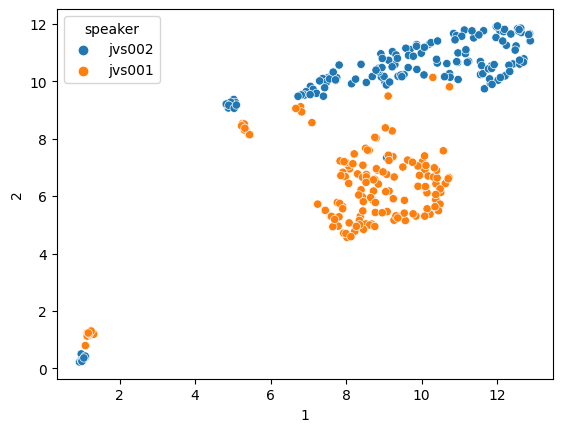

In [8]:
import umap
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
df = pd.DataFrame()
df['speaker'] = speakers
df['embedding'] = [o.squeeze(0) for o in outputs]
plot_df = df[df['speaker'].str.contains('jvs001|jvs002',regex=True)]
u = umap.UMAP().fit_transform( np.stack(plot_df['embedding'].to_list()))
plot_df['1'] = u[:,0]
plot_df['2'] = u[:,1]
sns.scatterplot(data=plot_df,x='1',y='2',hue='speaker')
plt.show()

In [10]:
np.stack(outputs).shape

(14997, 1, 80)

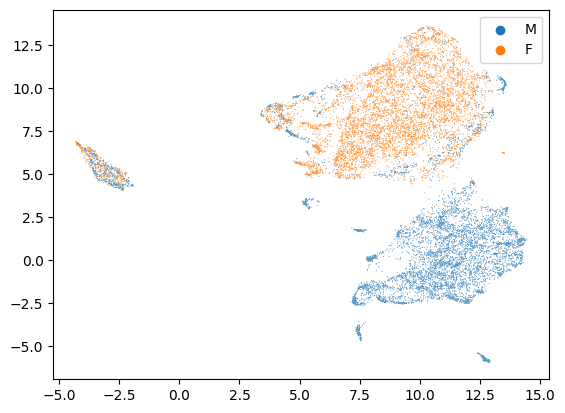

In [13]:
import umap
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
u = umap.UMAP().fit_transform( np.stack(outputs).squeeze(1))
sns.scatterplot(x=u[:,0],y=u[:,1],hue=np.stack([gender[s] for s in speakers]),s=0.5)
plt.show()

In [16]:
import torchaudio
import torch
from pathlib import Path
from tqdm import tqdm
import random
wav_files = list(Path("/mnt/hdd/datasets/jvs_ver1/").glob("**/VOICEACTRESS100_*.wav"))
wav_files = random.sample(wav_files,1000)
phoneme_outputs = []
filenames = []
outputs = []
speakers = []
for wav_file in tqdm(wav_files):
    alignment_file = Path(f"/mnt/hdd/datasets/jvs_ver1/jvs_r9y9-dev/aligned_labels_openjtalk/{wav_file.parents[2].name}/{wav_file.stem}.lab")
    if not alignment_file.exists():
        continue
    with alignment_file.open() as f:
        lines = f.readlines()
    wav_tensor,sr = torchaudio.load(wav_file)
    wav_tensor = torchaudio.functional.resample(waveform=wav_tensor,orig_freq=sr,new_freq=22_050)
    with torch.no_grad():
        output = mel_spec(wav_tensor)
    speaker = wav_file.parents[2].name
    for l in lines:
        s,e,p = l.strip().split()
        start_index = int(float(s)*22_050/256.0)
        end_index = int(float(e)*22_050/256.0)
        outputs.append(output[:,:,start_index:end_index].mean(axis=2).squeeze().cpu().numpy())
        phoneme_outputs.append(p)
        speakers.append(speaker)
        filenames.append(wav_file)

100%|██████████| 1000/1000 [02:17<00:00,  7.28it/s]


13

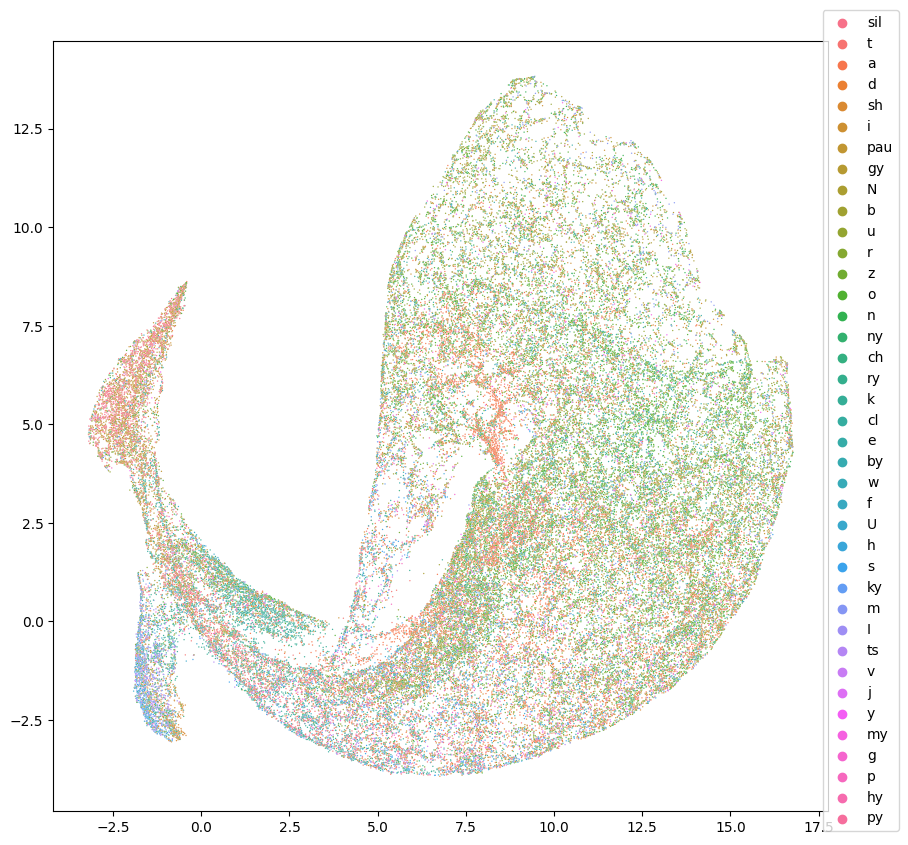

In [30]:
import umap
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,10))
u = umap.UMAP().fit_transform( np.stack(outputs)[~np.isnan(np.stack(outputs)).any(axis=1)])
ax = sns.scatterplot(x=u[:,0],y=u[:,1],hue=np.stack(phoneme_outputs)[~np.isnan(np.stack(outputs)).any(axis=1)],s=1)
ax.legend(bbox_to_anchor=(1.1, 1.05))